## Environment setup

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu Apr 24 10:29:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

In [1]:
!pip install -q inference-gpu
!pip install -q trackers[deepsort]==2.0.0rc2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.9 MB/s eta 0:00:

In [2]:
!pip list | grep supervision
!pip list | grep trackers

supervision                           0.26.0rc7
trackers                              2.0.0rc2


### Download example data

In [ ]:
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/bikes-1280x720-1.mp4
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/bikes-1280x720-2.mp4

## Track objects

### Initiate detector and tracker

In [8]:
from inference import get_model
from trackers import DeepSORTFeatureExtractor, DeepSORTTracker

# model = get_model("gunny-bags-ggndq/1" ,api_key="Jo5tS4jAZ66dqwdP8GqL")
model = get_model("yolov8m-640")


feature_extractor = DeepSORTFeatureExtractor.from_timm(
    model_name="mobilenetv4_conv_small.e1200_r224_in1k")

tracker = DeepSORTTracker(feature_extractor=feature_extractor)

### Configure annotators

In [9]:
import supervision as sv

color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

box_annotator = sv.BoxAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK)

trace_annotator = sv.TraceAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK,
    thickness=2,
    trace_length=100)

label_annotator = sv.LabelAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK,
    text_color=sv.Color.BLACK,
    text_scale=0.8)

### Run detection + tracking

In [13]:
CONFIDENCE_THRESHOLD = 0.3
NMS_THRESHOLD = 0.3

import numpy as np
SOURCE_VIDEO_PATH = "/content/gunny.mp4"
TARGET_VIDEO_PATH = "/content/gunny-output.mp4"


frame_samples = []

TARGET_CLASSES = [0, 24] # Example: 0 for 'person', 24 for 'backpack' in COCO dataset

def callback(frame, i):
    result = model.infer(frame, confidence=CONFIDENCE_THRESHOLD)[0]
    detections = sv.Detections.from_inference(result).with_nms(threshold=NMS_THRESHOLD)

    # Filter detections to include only target classes
    # Use a boolean mask to filter detections based on class_id
    # Use np.isin to check if each class_id is in TARGET_CLASSES
    mask = np.isin(detections.class_id, TARGET_CLASSES)
    detections = detections[mask]

    detections = tracker.update(detections, frame=frame)

    annotated_image = frame.copy()
    annotated_image = box_annotator.annotate(annotated_image, detections)
    annotated_image = trace_annotator.annotate(annotated_image, detections)
    # Ensure detections.tracker_id is not None before passing it to label_annotator
    labels = [
        f"#{tracker_id}"
        for tracker_id
        in detections.tracker_id
    ] if detections.tracker_id is not None else []

    annotated_image = label_annotator.annotate(
        scene=annotated_image, detections=detections, labels=labels)

    if i % 30 == 0 and i != 0:
        frame_samples.append(annotated_image)

    return annotated_image


tracker.reset()

sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback,
    show_progress=True,
)

Processing video:   0%|          | 0/1595 [00:00<?, ?it/s]

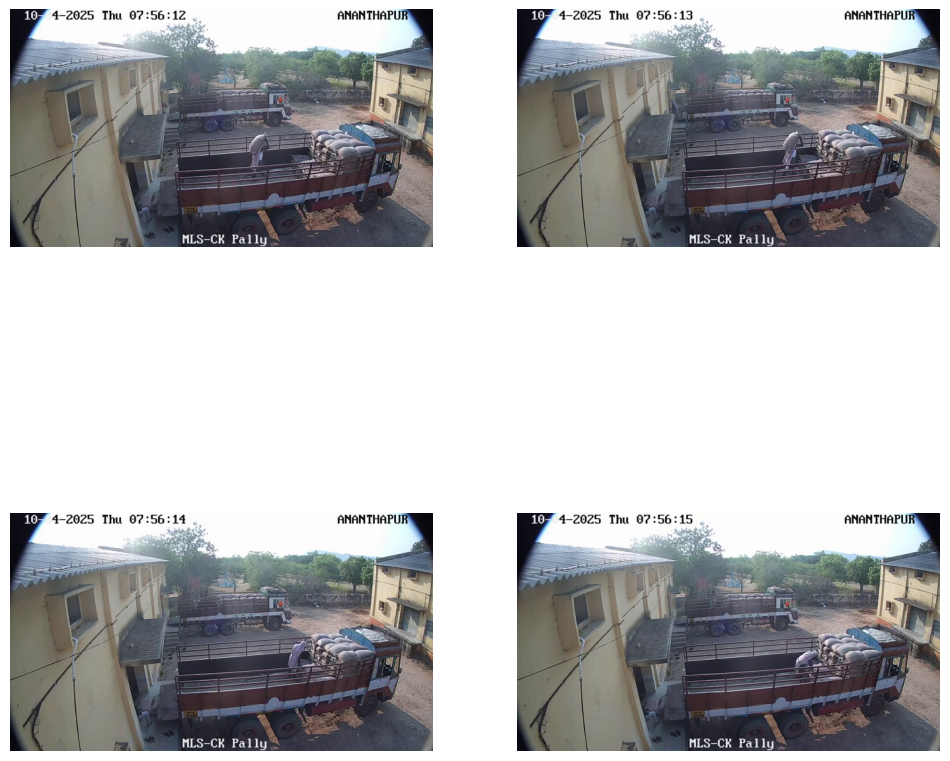

In [15]:
sv.plot_images_grid(images=frame_samples[:4], grid_size=(2, 2))

Just combined SORT with an `inference` detector—nice work! `trackers` makes it easy to mix and match top-performing multi-object tracking algorithms with your favorite detection backends, including `inference`, `ultralytics`, and `transformers`.

Ready to go deeper. Explore more tracking algorithms and integrations in the trackers [Documentation](https://roboflow.github.io/trackers/develop/) or dive into the code on [GitHub](https://github.com/roboflow/trackers). Got feedback or ideas, open an issue on [GitHub Issues](https://github.com/roboflow/trackers/issues).